# HybridNetv7MA Report

Jakob Balkovec<br>
Sat Sep 13th 2025<br>

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
from matplotlib.patches import Patch
import matplotlib.image as mpimg

ROOT_DIR = r'/Users/jbalkovec/Desktop/DR/experiments/model_logs/v7MA/output'
PATHS = {
  'per_image_test': os.path.join(ROOT_DIR, 'test_per_image_metrics.csv'),
  'metrics': os.path.join(ROOT_DIR, 'metrics_expanded.csv'),
  'split': os.path.join(ROOT_DIR, 'metrics_logs/split_summary.csv'),
}

## Utility Functions

In [8]:
def get_color(d):
    if d < 0.4:
        return "red"
    elif d < 0.5:
        return "yellow"
    else:
        return "green"

def plot_scatter_per_img_dice(df):
    plt.figure(figsize=(10, 8))
    plt.scatter(
        df["dice"],
        df["idx"],
        c=df["color"],
        s=80,
        marker="o",
        edgecolor="k",
        alpha=0.9
    )

    plt.axvline(0.4, color="red", linestyle="--", alpha=0.7, linewidth=1.2)
    plt.axvline(0.5, color="green", linestyle="--", alpha=0.7, linewidth=1.2)

    plt.xlabel("Dice Score", fontsize=13)
    plt.ylabel("Image Index", fontsize=13)
    plt.title("Per-Image Dice Scores", fontsize=15, fontweight="bold")

    legend_elements = [
        Patch(facecolor="red", edgecolor="k", label="Dice < 0.4"),
        Patch(facecolor="yellow", edgecolor="k", label="0.4 ≤ Dice < 0.5"),
        Patch(facecolor="green", edgecolor="k", label="Dice ≥ 0.5"),
    ]
    plt.legend(handles=legend_elements, title="Score Ranges", loc="lower right", frameon=True)

    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

BANDS = {
    "loss": {
        "good": (0.0, 0.25),
        "mid":  (0.25, 0.45),
        "bad":  (0.45, float("inf")),
    },
    "dice": {
        "bad":  (0.0, 0.40),
        "mid":  (0.40, 0.60),
        "good": (0.60, 1.0),
    },
    "iou": {
        "bad":  (0.0, 0.30),
        "mid":  (0.30, 0.45),
        "good": (0.45, 1.0),
    },
    "pearson": {
        "bad":  (0.0, 0.30),
        "mid":  (0.30, 0.50),
        "good": (0.50, 1.0),
    },
}

BAND_COLORS = {"bad": "#F44336", "mid": "#FFC107", "good": "#4CAF50"}

def _get_epoch_x(df):
    if "epoch" in df.columns:
        return df["epoch"].values
    return (df.index.values + 1)

def _shade_bands(ax, metric, x_min, x_max, alpha=0.15):
    if metric not in BANDS:
        return

    for band in ("bad", "mid", "good"):
        lo, hi = BANDS[metric][band]
        ax.axhspan(lo, hi if hi != float("inf") else ax.get_ylim()[1],
                   color=BAND_COLORS[band], alpha=alpha, zorder=0, linewidth=0)

def plot_metric(df, metric, title=None, ylim=None):
    tr_col = f"train_{metric}"
    va_col = f"val_{metric}"
    if tr_col not in df.columns or va_col not in df.columns:
        raise ValueError(f"Expected columns '{tr_col}' and '{va_col}' in df")

    x = _get_epoch_x(df)
    y_tr = df[tr_col].values
    y_va = df[va_col].values

    fig, ax = plt.subplots(figsize=(8, 5))

    y_min = min(y_tr.min(), y_va.min())
    y_max = max(y_tr.max(), y_va.max())
    if ylim is None:
        if metric in ("dice", "iou", "pearson"):
            ylim = (0.0, 1.0)
        else:
            ylim = (max(0.0, y_min * 0.9), y_max * 1.1)

    ax.set_ylim(*ylim)
    _shade_bands(ax, metric, x_min=x.min(), x_max=x.max(), alpha=0.18)

    ax.plot(x, y_tr, marker="o", linewidth=1.8, markersize=5, label=f"train_{metric}")
    ax.plot(x, y_va, marker="s", linewidth=1.8, markersize=5, label=f"val_{metric}")

    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric.capitalize())
    ax.set_title(title or f"{metric.capitalize()} (train vs val)")
    ax.grid(True, axis="both", linestyle="--", alpha=0.4)
    ax.legend(loc="best", frameon=True)

    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    return fig, ax

def plot_panel(img):
    plt.figure(figsize=(10, 16))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Best Panel")
    plt.show()

In [9]:
per_image_test_df = pd.read_csv(PATHS['per_image_test'])
metrics_df = pd.read_csv(PATHS['metrics'])

## Per-Image Test Results

This is here to analyze per-image dice scores, and rule out the outliers.

#### Tail

In [10]:
sorted_per_img = per_image_test_df.sort_values('dice')
sorted_per_img.head(n=10)

,image_id,dice,iou,precision,recall,pearson
128,0660_1,7.390983e-10,7.390983e-10,0.0,0.0,-0.000454
126,0650_1,8.849558e-10,8.849558e-10,0.0,0.0,0.047304
21,0106_1,9.615384e-10,9.615384e-10,0.0,0.0,0.000000
195,0945_1,1.123596e-09,1.123596e-09,0.0,0.0,0.000000
91,0478_1,1.177856e-09,1.177856e-09,0.0,0.0,0.074317
184,0901_1,1.449275e-09,1.449275e-09,0.0,0.0,0.000000
88,0465_1,1.522070e-09,1.522070e-09,0.0,0.0,0.000000
271,1804_3,1.934236e-09,1.934236e-09,0.0,0.0,-0.000268
205,0981_1,2.008032e-09,2.008032e-09,0.0,0.0,0.085418
103,0532_1,2.617801e-09,2.617801e-09,0.0,0.0,-0.000707


#### Head

In [11]:
sorted_per_img.tail(n=10)

,image_id,dice,iou,precision,recall,pearson
203,0974_1,1.0,1.0,0.0,0.0,0.0
242,1187_1,1.0,1.0,0.0,0.0,0.0
202,0968_1,1.0,1.0,0.0,0.0,0.0
201,0964_1,1.0,1.0,0.0,0.0,0.0
49,0254_1,1.0,1.0,0.0,0.0,0.0
17,0085_1,1.0,1.0,0.0,0.0,0.0
54,0280_1,1.0,1.0,0.0,0.0,0.0
55,0286_1,1.0,1.0,0.0,0.0,0.0
30,0158_1,1.0,1.0,0.0,0.0,0.0
48,0247_1,1.0,1.0,0.0,0.0,0.0


This doesn't really mean anything, since the tail is just images with no masks, and head is the images with the largest masks. Setting a threshold for dice scores to be above 0.5 seems reasonable. Anything above that is good, anything below that is considered a failure.

In [13]:
print("MEAN: ", per_image_test_df["dice"].mean().round(3))

MEAN:  0.478


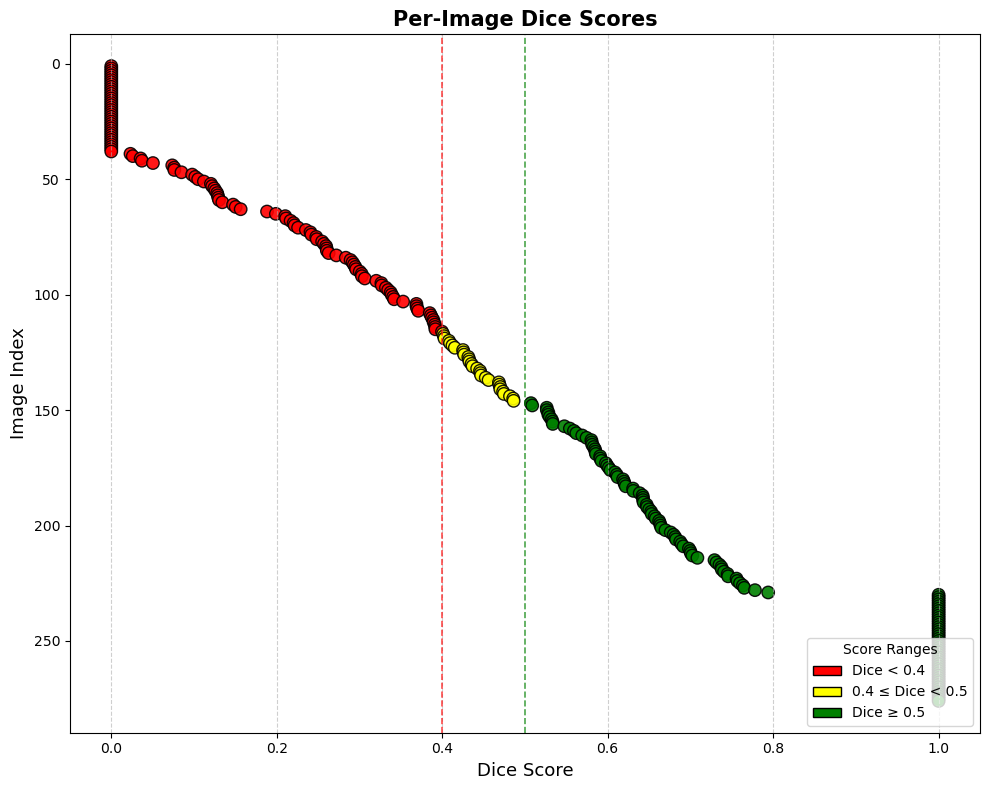

In [14]:
per_image_test_df["color"] = per_image_test_df["dice"].apply(get_color)
per_image_test_df = per_image_test_df.sort_values("dice").reset_index(drop=True)
per_image_test_df["idx"] = per_image_test_df.index + 1  # 1-based

plot_scatter_per_img_dice(per_image_test_df)

As I mentioned above, a dice score of 1 means that the predicted mask matches the ground truth perfectly. From my brief analysis, the images with a dice score of 1 have no masks/blank masks. A dice score of 0 means that there is no overlap at all:

- The model completely failed to detect the annotated lesions (missed all true lesions), 
- The model predicted lesions in entirely different regions of the fundus where none exist in the ground truth.

#### Removing Outliers

In [15]:
filtered_df = per_image_test_df[(per_image_test_df["dice"] > 0.05) & (per_image_test_df["dice"] < 0.99)]
print("New length: ", len(filtered_df), " vs. Old length: ", len(per_image_test_df))

New length:  187  vs. Old length:  276


`USING LOWER_BOUND == 0.05 && UPPER_BOUND == 0.99`

- I set the lower bound to be 0.05 to exclude the images where the model completely failed to detect any lesions. 
- I set the upper bound to be 0.99 to exclude the images where there are no lesions in the ground truth, which results in a dice score of 1. These outliers can skew the mean dice score and give a false impression of the model's performance.

`89 OUTLIERS`

**Note:** Compared to 130 with EX and 75 with HE

Now that the `89` outliers have been identified and removed, we can calculate a more accurate mean dice score. Note that these are not the dice scores obtained during training, but the dice scores calculated on the test set after training.

`SCALED UP`

If 276 images have 75 outliers, that means that 34.7% of the images are outliers. Scaling this up to the full dataset of 1820 images, we can expect around 633 images to be outliers. This is a significant portion of the dataset, and it highlights the importance of addressing these outliers in order to improve the overall performance of the model...

In [16]:
print("True MEAN: ", filtered_df["dice"].mean().round(3))
print("True MEDIAN: ", round(filtered_df["dice"].median(), ndigits=3))

True MEAN:  0.454
True MEDIAN:  0.453


Now this is the actual mean dice score after removing the outliers. it indicates poor performance, but this is expected given the difficulty of the task and the presence of many challenging images in the dataset...It's not too far off from the mean dice score over all images, which was 0.446. This suggests that the outliers were not drastically skewing the overall performance metrics, but their removal does provide a clearer picture of the model's capabilities on more typical cases.

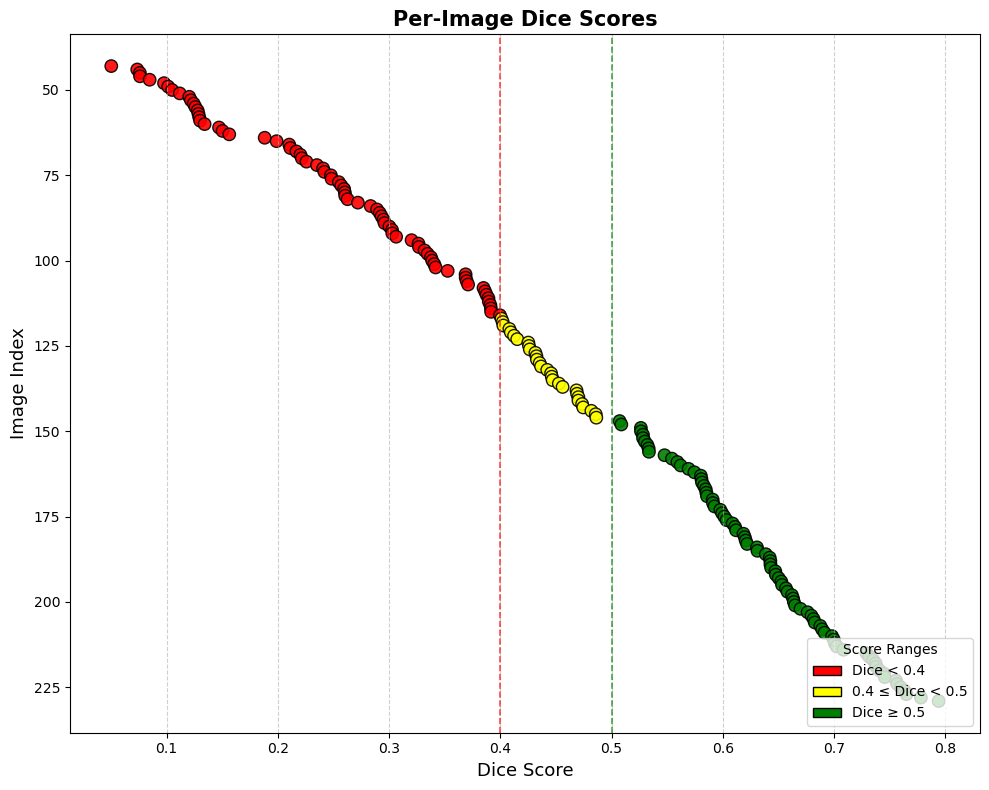

In [17]:
plot_scatter_per_img_dice(filtered_df)

## Standard Metrics

In [18]:
metrics_df.head(n=19)

,epoch,train_loss,val_loss,train_dice,val_dice,train_iou,val_iou,train_pearson,val_pearson
0,1,1.053959,0.566184,0.585422,0.315975,0.425187,0.212878,0.602077,0.330937
1,2,0.887446,0.560013,0.359457,0.358125,0.229321,0.267963,0.452780,0.315419
2,3,0.830194,0.556069,0.267242,0.389790,0.173545,0.298203,0.315760,0.318573
3,4,0.790324,0.512588,0.487255,0.413484,0.322999,0.305328,0.516656,0.369045
4,5,0.742125,0.522331,0.535997,0.443561,0.382423,0.341147,0.575906,0.356340
5,6,0.710720,0.511287,0.164882,0.446811,0.098718,0.345576,0.226148,0.361578
6,7,0.689430,0.530738,0.360700,0.422901,0.282105,0.326315,0.372587,0.340093
7,8,0.682737,0.505514,0.347351,0.468827,0.266108,0.364808,0.358267,0.372099
8,9,0.659165,0.543182,0.020015,0.418038,0.010212,0.328135,0.055456,0.322954
9,10,0.652292,0.504950,0.391154,0.468393,0.306766,0.363348,0.447148,0.377933


#### Dice

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Training and Validation Dice Over Epochs'}, xlabel='Epoch', ylabel='Dice'>)

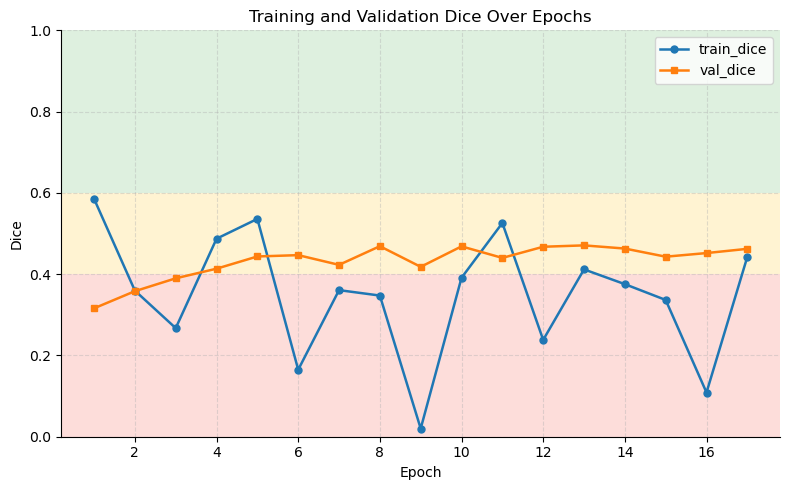

In [19]:
plot_metric(metrics_df, "dice", title="Training and Validation Dice Over Epochs")

#### IoU

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Training and Validation IoU Over Epochs'}, xlabel='Epoch', ylabel='Iou'>)

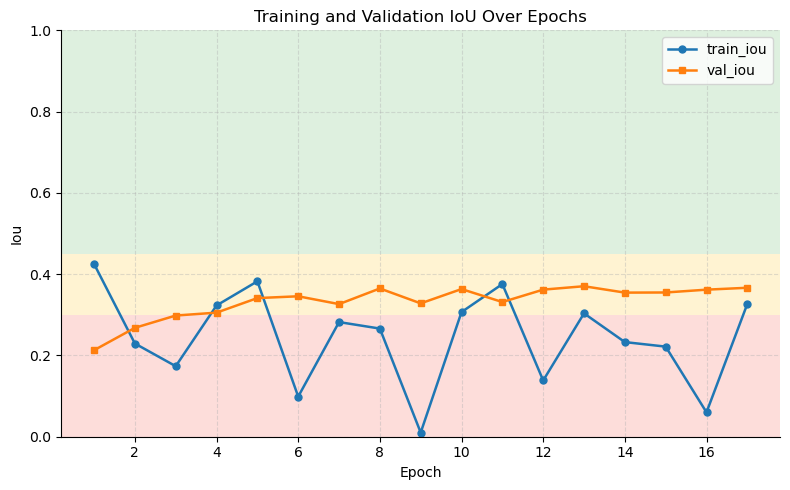

In [20]:
plot_metric(metrics_df, "iou", title="Training and Validation IoU Over Epochs")

#### Pearson's R

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': "Training and Validation Pearson's R Over Epochs"}, xlabel='Epoch', ylabel='Pearson'>)

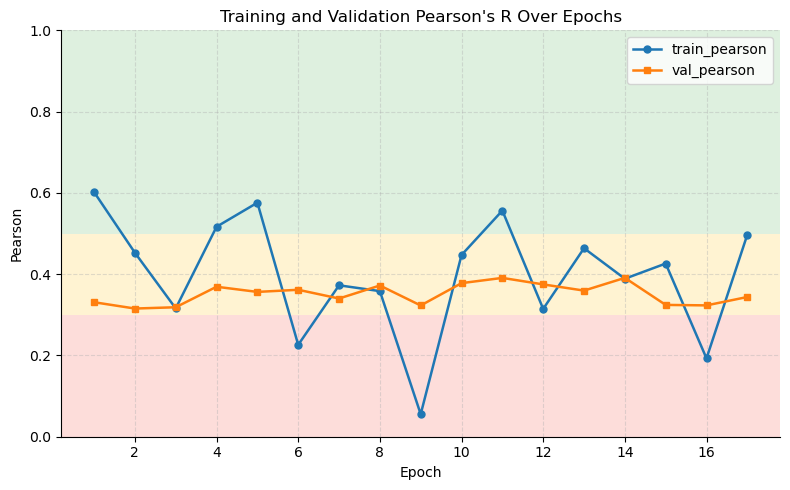

In [21]:
plot_metric(metrics_df, "pearson", title="Training and Validation Pearson's R Over Epochs")

The metrics don't look horrible, but they're not great either. This could be a mild case of overfitting I guess, but I think a bigger problem is that the model is just not powerful enough to capture the complexity of the data. The training and validation metrics are pretty close, which suggests that the model is learning something useful, but it's not learning it well enough to generalize to new data...

## Low-Dice Panels

#### Best

The panels with high dice (< 0.95) are not worth plotting since they're just images with no lesions. The model predicts no lesions, which is correct, but the dice score is 1 because there are no true positives. I plotted 1 just an example.

Note that the grid pattern is as follows:

| IMG + M1 | PRED M1   | PRED  M2  |
|------|------|------|
| IMG + M2 | IMG + M3 | PRED M3 |


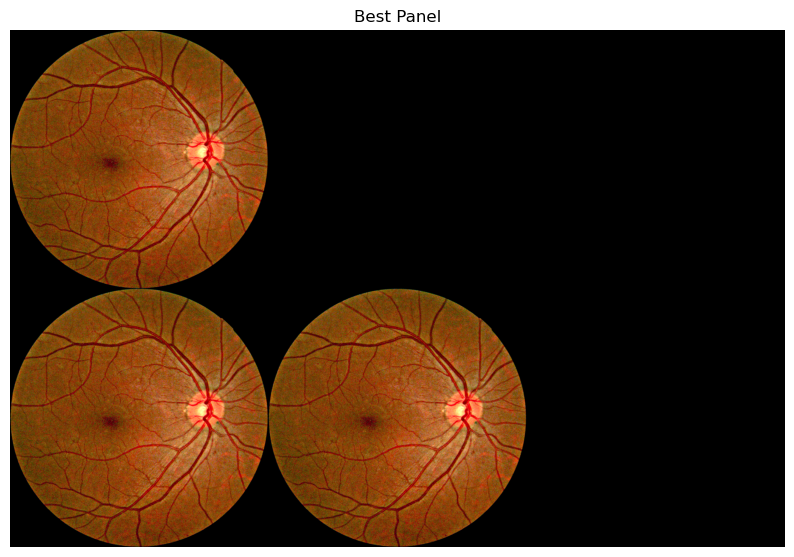

In [23]:
path = r'/Users/jbalkovec/Desktop/DR/experiments/model_logs/v7MA/output/error_analysis/best/00_1629_1_dice1.000.png'
img = mpimg.imread(path)

plot_panel(img)

#### Worst

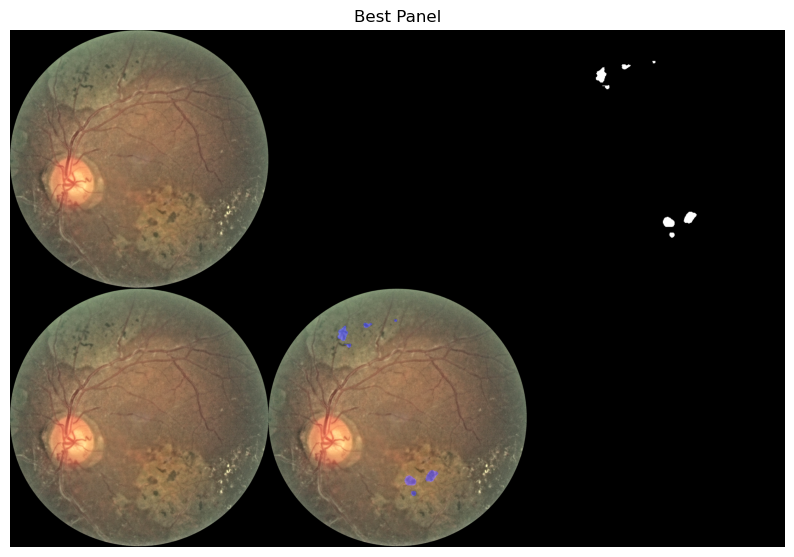

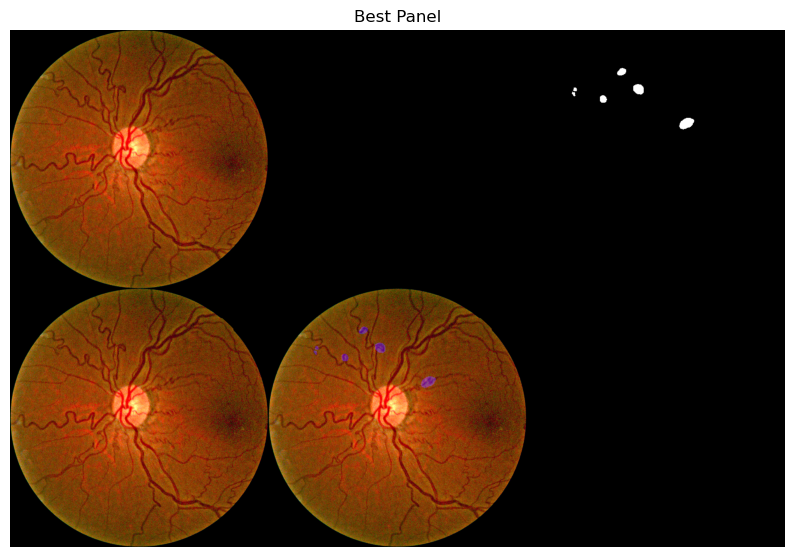

In [24]:
PANEL1 = r'/Users/jbalkovec/Desktop/DR/experiments/model_logs/v7MA/output/error_analysis/worst/03_1801_3_dice0.000.png'
PANEL2 = r'/Users/jbalkovec/Desktop/DR/experiments/model_logs/v7MA/output/error_analysis/worst/04_1410_1_dice0.000.png'

plot_panel(mpimg.imread(PANEL1))
plot_panel(mpimg.imread(PANEL2))

So the goal of this was to identify pattern(s) that hurt the dice score. I don't really see a definitive pattern, but I do see a common theme, that is if the lesion is relatively small, e.g. meaning a lot of background, the model tends to miss it/struggle. This is especially true if the lesion is in a tricky spot, like near the optic disc or fovea. The model seems to have a hard time distinguishing between actual lesions and other features of the retina, like blood vessels or reflections.

I'm curious to see if Daniel and Alyssa notice the same patterns when they do their analysis. It would be interesting to see if they come to the same conclusions, or if they notice different things that I missed...

## Further Investigation

Since I felt like this wasn't enough, I decided to compile a list of images with low (close to 0) dice score and investigate them further. I was mostly focused on predicted masks vs ground truth masks. 



#### Zero Dice Breakdown

In [25]:
zero_dice_df = pd.read_csv(r'/Users/jbalkovec/Desktop/DR/experiments/model_logs/v7MA/output/per_image_analysis/zero_dice_breakdown.csv')

In [26]:
case_counts = zero_dice_df["case"].value_counts()
print("\nCounts per failure type:\n", case_counts)


Counts per failure type:
 case
C_disjoint    24
Name: count, dtype: int64


- `C_disjoint` means Both GT and prediction are non-empty,
  but they do not overlap at all = mislocalization (wrong region).

All of the zero-Dice failures in this batch turned out to be `C-disjoint` cases, meaning the model did predict lesions but in the completely wrong spots.

In other words, ground truth and predictions never overlapped once. This shows the network isn’t just being cautious; it’s actively focusing on the wrong regions. Most likely, it’s latching onto background textures or vessel patterns instead of the actual annotated lesions, which points to a bigger issue with localization rather than just sensitivity...

## Test Results

In [ ]:
json = {
  "dice": 0.48,
  "iou": 0.38,
  "precision": 0.51,
  "recall": 0.26,
  "pearson": 0.345,
  "threshold": 0.2,
  "post_min_area": 12,
  "lesion": "HE",
}

---
Jakob Balkovec